# Lab 14: Playing Atari games with Deep Reinforcement Learning

Material for this lab comes from these sources:
 - Pytorch 1.x Reinforcement Learning Cookbook (Packtpub)
 - Hands-On Reinforcement Learning for Games (Packtpub)

## Deep Q-Learning

Last time we implemented Q learning and made a first attempt at replacing the Q table with a deep neural network.

A deep Q-Network (DQN) is similar to a supervised regression model $F_{\theta}$, but it more specifically maps states to action values directly instead of using a set of features.

A DQN is trained to output $Q(s,a)$ values for each action given the input state $s$. In operation, in state $s$, the action $a$ is chosen greedily based on $Q(s,a)$ or stochastically
following an epsilon-greedy policy.

<img src="img/RL2_DQN.png" title="DQN" style="width: 800px;" />

In tabular Q learning, the update rule is an off-policy TD learning rule. When we take
action $a$ in state $s$ receiving reward $r$, we update $Q(s,a)$ as

$$Q(s,a)=Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a')-Q(s,a)),$$

where
 - $s'$ is the resulting state after taking action $a$ in state $s$
 - $\max_{a'}Q(s',a')$ is value of the action $a'$ we would take in state $s'$ according to a greedy behavior policy.

A DQN does the same thing using backpropagation, minimizing inconsistencies in its $Q$ estimates. At each step, the difference
between the estimated value and the observed data from the subsequent step should be minimized, giving us a kind of regression
problem, for which a squared error loss function is appopriate, giving us a delta for the $a$th output of

$$\delta_a=r+\gamma\max_{a'}Q(s')_{a'}-Q(s)_{a}.$$

With an appropriate exploration strategy and learning rate, DQN should find the optimal network model best approximating
the state-value function $Q(s,a)$ for each possible state and action.

## DQN Example: Cartpole

Let's develop a sample DQN application step by step. First, some imports we'll need.
We'll use the `gym` package like last week.

In [2]:
import math, random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np

from collections import deque
from tqdm import trange

# Select GPU or CPU as device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### $\epsilon$ decay schedule

Recall that some of the theoretical results on TD learning assume $\epsilon$-greedy exploration with $\epsilon$ decaying slowly to 0
over time. Let's define an exponential decay schedule for $\epsilon$. First, an example:


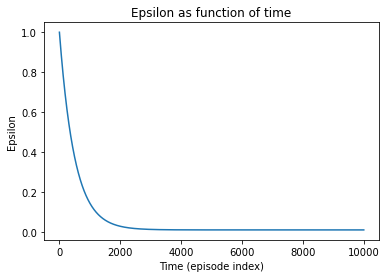

In [8]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

# Define epsilon as a function of time (episode index)

eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

# Note that the above lambda expression is equivalent to explicitly defining a function:
# def epsilon_episode(episode):
#     return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

plt.plot([eps_by_episode(i) for i in range(10000)])
plt.title('Epsilon as function of time')
plt.xlabel('Time (episode index)')
plt.ylabel('Epsilon')
plt.show()


Here's a reusable function to generate an annealing schedule function according to given parameters:

In [9]:
# Epsilon annealing schedule generator

def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

### Basic DQN

Next, a basic DQN class. We just create a neural network that takes as input a state
and returns an output vector indiciating the value of each possible action $Q(s,a)$.

The steps we take during learning will be as follows:

<img src="img/RL2_DQNstep.jpeg" title="" style="width: 600px;" />

To implement the policy, besides the usual `forward()` method, we add one additional method `act()`,
which samples an $\epsilon$-greedy action for state $s$ using the current estimate $Q(s,a)$.
`act()` will be used to implement step 1 in the pseudocode above.


### Plot rewards and losses

Here's a little function to plot relevant details for us:

In [16]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show() 

### Play in the simulation

You can run your simulation in Jupyter if you have OpenGL installed, but after the simulation is finished, you must close the
simulator with `env.close()` (this closes the simulator, not the environment).

In [ ]:
import time
def play_game(model):
    done = False
    state = env.reset()
    while(not done):
        action = model.act(state, epsilon_final)
        next_state, reward, done, _ = env.step(action)
        env.render()
        time.sleep(0.03)
        state = next_state

play_game(model)
time.sleep(3)
env.close()

## Applying DQN to Atari games

How about Atari games? It's possible as we
saw from the Mnih et al. (2015) paper in *Nature*, but since the game has *images* as inputs, we have to from image inputs to look like states
to the DQN model.

In the example below, we get a state image, convert to grayscale, and reshape it into a 1D vector for input to the DQN class.

Let's play *Pong*, the first commercially successful video game.

Here's a screen processing function to downsize the image and convert to grayscale:

In [13]:
import torchvision.transforms as T
from PIL import Image
image_size = 84

transform = T.Compose([T.ToPILImage(),  # from tensors to image data
                       T.Grayscale(num_output_channels=1), # convert to grayscale with 1 channel
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC), # resize to 84*84 by using Cubic interpolation
                       T.ToTensor()]) # convert back to tensor

def get_state(observation):
    # Numpy: Use transpose(a, argsort(axes)) to invert the transposition of tensors when using the axes keyword argument.
    # Example: x = np.ones((1, 2, 3))
    # np.transpose(x, (1, 0, 2)).shape --> (2, 1, 3)
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state

Let's change the DQN input to be an 84$\times$84 image:

In [15]:
def play_game2(model):
    done = False
    obs = env.reset()
    # convert observation state to image state, and reshape as 1D size
    state = get_state(obs).view(image_size * image_size)
    #################################################################
    while(not done):
        action = model.act(state, epsilon_final)
        next_obs, reward, done, _ = env.step(action)
        # convert observation state to image state, and reshape as 1D size
        next_state = get_state(next_obs).view(image_size * image_size)
        #################################################################
        env.render()
        time.sleep(0.03)
        state = next_state

Wooooo! How easy!!!

## Other Atari games: Space Invaders

Now let's try Space Invaders.

In [16]:
transform = T.Compose([T.ToPILImage(),
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC),
                       T.ToTensor()])

# Convert to RGB image (3 channels)

def get_state2(observation):
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state

## Double DQN

The Double DQN is is a deep learning version of
the double Q learning algorithm. The idea is to use one DQN for
learning and another DQN to provide the learning targets, making learning
more stable. The double DQN was introduced by, you guessed it, Google DeepMind, again!
You can read the details in [the double DQN paper](https://arxiv.org/pdf/1509.06461.pdf).

The two networks are called the prediction network and the target network. The learning rule is

$$\delta=r+\gamma\max_a Q_T(s',a':\theta_t^-) - Q(s).$$

$Q_T$ is the target generating network, and $Q$ is the prediction network. 

In [28]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

# Initialization

update_target(current_model, target_model)

## Dueling DQN or the real DDQNs

When you think about dueling, it must be Dread Pirate Roberts and Enigo Montoya...

<img src="img/princess-bride.png" title="" style="width: 600px;" />

Oops!!! sorry, just kidding ;P

### What is DDQNs?

To see the details, read the [Dueling DQNs (DDQNs) paper](https://arxiv.org/abs/1511.06581).

DDQNs are different from the double DQNs. Both variations assume some form of duality,
but while double DQN has two separate models, the DDQN is one model split at the base.

<img src="img/RL2_DDQN3.png" title="" style="width: 800px;" />

DDQN extends the concept of a fixed Q target and extends that to a concept called *advantage*.
The advantage indicates what additional value one action has against other actions.
The Q-value in DDQNs is computed with the following two functions:

$$Q(s,a)=V(s)+A(s,a)-\frac{1}{|A|}\sum_{a'=1}^{|A|} A(s,a')$$

 - $V(s)$: state-value function, the value of being in state $s$
 - $A(s,a)$: state-dependent action advantage function, estimating how much better it is to take an action $a$ than other actions $a'$ in the same state

In [33]:
class DDQN(nn.Module):
    def __init__(self, n_channel, n_action):
        super(DDQN, self).__init__()        
        
        self.conv1 = nn.Conv2d(in_channels=n_channel, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        
        # advantage layer: output is n_action as usual
        self.advantage = nn.Sequential(
            nn.Linear(7*7*64, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )
        
        # policy value: value action
        self.value = nn.Sequential(
            nn.Linear(7*7*64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        advantage = self.advantage(x)
        value     = self.value(x)

        # recalculate Q-value
        return value + advantage - advantage.mean()
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

## Prioritized experience replay

The replay buffer or experience replay mechanism allows us to values in batches at a later time in order to train the network.
Up till now, our batches are random samples from the buffer.
However, some samples would be better than others, so we don't need to store everything. We can make two decisions:
 - What data to store
 - What priority to use

Let's develop a version of the replay buffer that tracks priority from experience replay,
so we can predict where the agent should spend its learning capacity.

In [37]:
class NaivePrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def push(self, state, action, reward, next_state, done):
        assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        # check maximum priority
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        # add it or replace it
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        # calculate priority
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)
        
        batch       = list(zip(*samples))
        states      = np.concatenate(batch[0])
        actions     = batch[1]
        rewards     = batch[2]
        next_states = np.concatenate(batch[3])
        dones       = batch[4]
        
        return states, actions, rewards, next_states, dones, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(list(batch_indices), [batch_priorities]):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

### Importance-sampling

Here we define a value $\beta$ indicating the importance of experience, focusing more on the recent experience
than on outdated experience:


In [38]:
episodes = 200000
batch_size = 64
gamma      = 0.99
min_play_reward = -.15

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = episodes / 10
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

# defind a function to return an increasing beta over episodes
beta_start = 0.4
beta_episodes = episodes / 10
def gen_beta_by_episode(beta_start, beta_episodes):
    beta_by_episode = lambda episode: min(1.0, beta_start + episode * (1.0 - beta_start) / beta_episodes)
    return beta_by_episode

beta_by_episode = gen_beta_by_episode(beta_start, beta_episodes)

In [39]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

current_model = DDQN(3, env.action_space.n).to(device)
target_model  = DDQN(3, env.action_space.n).to(device)

optimizer = optim.Adam(current_model.parameters())

# Change from Normal replay buffer to be prioritize buffer
#replay_buffer = ReplayBuffer(100000)
replay_buffer = NaivePrioritizedBuffer(100000)

update_target(current_model, target_model)

In [40]:
def compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma=0.99, beta=0.4):
    # get data from replay mode
    # state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)

    # convert to tensors
    # Autograd automatically supports Tensors with requires_grad set to True.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)
    weights    = autograd.Variable(torch.FloatTensor(weights)).to(device)

    # calculate q-values and next q-values from deeplearning
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    # double DQN add here
    #next_q_state_values = target_model(next_state)

    # get q-value from propagated action in each step
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # double DQN different here
    #next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    # calculate expected q-value from q-function
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # calculate loss value
    # loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
    prios = loss + 1e-5
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()

    return loss

In [41]:
def train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = 10000, batch_size=32, gamma = 0.99, min_play_reward=-.15):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    state = get_state2(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        avg_reward = tot_reward / (episode + 1)
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,avg_reward))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        next_state = get_state2(next_obs)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            state = get_state2(obs)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            beta = beta_by_episode(episode)
            loss = compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma, beta)
            losses.append(loss.item())

        if episode % 500 == 0:
            update_target(current_model, target_model)
            
    plot(episode, all_rewards, losses)  
    return current_model, target_model, all_rewards, losses

Agent training (episode200001) Avg Reward 0.269398653006735: 100%|██████████| 200001/200001 [30:55<00:00, 107.77it/s]


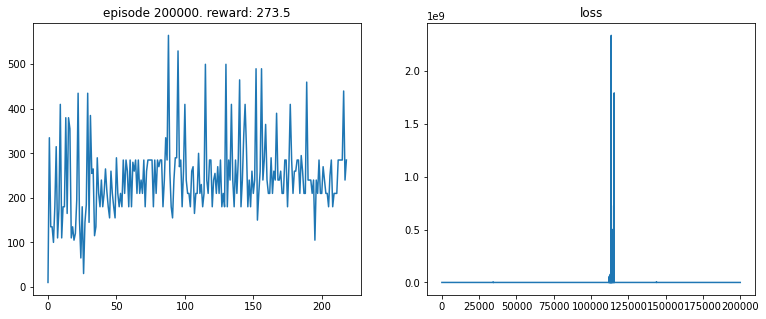

In [42]:
current_model, target_model, all_rewards, losses = train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = episodes, batch_size=batch_size, gamma = gamma, min_play_reward = min_play_reward)

In [45]:
play_game_CNN(current_model)
time.sleep(3)
env.close()

If you want to try more games, go ahead...

## Independent exercise

Recall that Mnih et al. (2015) obtained superhuman playing ability for some of the Atari games by combining DQN with
experience replay and a more sophisticated state representation that what we've seen so far: they stack successive
frames as the input state representation so as to give the agent some "velocity" input rather than a static snapshot
of the scene.

Try combining the techniques we've developed in the lab with the frame history as state, and get the best Space Invaders player you can.
What's your agent's average and best score over 100 games?
